<a href="https://colab.research.google.com/github/CanKeles5/ColorizeMountainAdversarial/blob/master/Bigger_model_RGB_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.utils.data.sampler
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader as DL
from torch.utils.data import *
from PIL import Image, ImageFilter
import os
import cv2
import numpy
import random
import fnmatch

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [0]:
! kaggle datasets download -d puneet6060/intel-image-classification

 96% 331M/346M [00:02<00:00, 102MB/s]
100% 346M/346M [00:02<00:00, 126MB/s]


In [0]:
path = "/content/intel-image-classification.zip"
to = "/content/dataset"
! unzip -q -n {path} -d {to}

In [0]:
image_folder = "/content/dataset/seg_train/seg_train/mountain"
image_paths = []

for dirname, _, filenames in os.walk(image_folder):
    for filename in filenames:
        if(fnmatch.fnmatch(dirname, '*mountain*')):
            image_paths.append(os.path.join(dirname, filename))

In [0]:
len(image_paths)

2512

In [0]:
class MyDataset(Dataset):
  def __init__(self, image_paths, train=True):
    self.image_paths = image_paths
  
  def transforms(self, image):
    tfms = transforms.Resize(size=(256, 256))
    
    tfms = transforms.Compose([
                              transforms.Resize(size=(256, 256)),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomRotation(degrees=5),
                              transforms.RandomPerspective(distortion_scale=0.05)
                              ])

    image = tfms(image)
    image = image.filter(ImageFilter.MedianFilter())
    image = TF.to_tensor(image)
    
    return image

  def __getitem__(self, index):
    image = Image.open(self.image_paths[index])
    x = self.transforms(image)

    return x
  
  def __len__(self):
    return len(self.image_paths)

In [0]:
class ValidateSet(Dataset):
  def __init__(self, image_paths, train=True):
    self.image_paths = image_paths
  
  def transforms(self, image):
    resize = transforms.Resize(size=(256, 256))
    image = resize(image)
    image = image.filter(ImageFilter.MedianFilter())
    image = TF.to_tensor(image)
    
    return image

  def __getitem__(self, index):
    image = Image.open(self.image_paths[index])
    x = self.transforms(image)

    return x
  
  def __len__(self):
    return len(self.image_paths)

In [0]:
dataset = MyDataset(image_paths[0:2500])
len(dataset)

2500

In [0]:
validate_set = ValidateSet(image_paths[2500: 2512])

In [0]:
train_indices = range(0,2300)
test_indices = range(2300, 2500)

In [0]:
batch_size = 4
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices))
validate_loader = torch.utils.data.DataLoader(validate_set, batch_size=batch_size)

Works with lr=1e-5

In [0]:
def en_double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True)
    )

def dec_double_conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

n=8

class G(nn.Module):
    def __init__(self):
        super().__init__()

        self.dconv_1 = en_double_conv(1, n)
        self.dconv_2 = en_double_conv(n, n*2)
        self.dconv_3 = en_double_conv(n*2, n*4)
        self.dconv_4 = en_double_conv(n*4, n*8)
        self.dconv_5 = en_double_conv(n*8, n*8)
        self.dconv_6 = en_double_conv(n*8, n*8)
        self.dconv_7 = en_double_conv(n*8, n*8)
        self.dconv_8 = en_double_conv(n*8, n*8)

        self.dropout = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool2d(2)

        self.TConv8 = nn.ConvTranspose2d(n*8, n*8, 4, 2, 1)
        self.TConv7 = nn.ConvTranspose2d(n*8*2, n*8*2, 4, 2, 1)
        self.TConv6 = nn.ConvTranspose2d(n*8*3, n*8*3, 4, 2, 1)
        self.TConv5 = nn.ConvTranspose2d(n*8*4, n*8*4, 4, 2, 1)
        self.TConv4 = nn.ConvTranspose2d(n*8*5, n*8*5, 4, 2, 1)
        self.TConv3 = nn.ConvTranspose2d(n*44, n*44, 4, 2, 1)
        self.TConv2 = nn.ConvTranspose2d(n*46, n*46, 4, 2, 1)
        self.TConv1 = nn.ConvTranspose2d(n*47, 3, 4, 2, 1)
        
    def forward(self, x):
        conv1 = self.dconv_1(x)
        conv1 = self.maxpool(conv1)

        conv2 = self.dconv_2(conv1)
        conv2 = self.maxpool(conv2)

        conv3 = self.dconv_3(conv2)
        conv3 = self.maxpool(conv3)

        conv4 = self.dconv_4(conv3)
        conv4 = self.maxpool(conv4)

        conv5 = self.dconv_5(conv4)
        conv5 = self.maxpool(conv5)

        conv6 = self.dconv_6(conv5)
        conv6 = self.maxpool(conv6)

        conv7 = self.dconv_7(conv6)
        conv7 = self.maxpool(conv7)

        conv8 = self.dconv_8(conv7)
        conv8 = self.maxpool(conv8)

        x = self.TConv8(conv8)

        x = torch.cat([x, conv7], dim=1)
        x = self.TConv7(x)
        x = self.dropout(x)

        x = torch.cat([x, conv6], dim=1)
        x = self.TConv6(x)
        x = self.dropout(x)

        x = torch.cat([x, conv5], dim=1)
        x = self.TConv5(x)
        x = self.dropout(x)

        x = torch.cat([x, conv4], dim=1)
        x = self.TConv4(x)
        x = self.dropout(x)

        x = torch.cat([x, conv3], dim=1)
        x = self.TConv3(x)
        x = self.dropout(x)

        x = torch.cat([x, conv2], dim=1)
        x = self.TConv2(x)
        x = self.dropout(x)

        x = torch.cat([x, conv1], dim=1)
        x = self.TConv1(x)
        x = nn.Tanh()(x)

        return x

Works with lr=1e-6

In [0]:
def en_double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True)
    )

def dec_double_conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )
n=8
class G2(nn.Module):
    def __init__(self):
        super().__init__()

        self.dconv_1 = en_double_conv(1, n)
        self.dconv_2 = en_double_conv(n, n*2)
        self.dconv_3 = en_double_conv(n*2, n*4)
        self.dconv_4 = en_double_conv(n*4, n*8)
        self.dconv_5 = en_double_conv(n*8, n*8)
        self.dconv_6 = en_double_conv(n*8, n*8)

        self.dropout = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool2d(2)

        self.upconv_6 = dec_double_conv(n*8, n*8)
        self.upconv_5 = dec_double_conv(n*8*2, n*8*2)
        self.upconv_4 = dec_double_conv(n*8*3, n*8*3)
        self.upconv_3 = dec_double_conv(n*28, n*28)
        self.upconv_2 = dec_double_conv(n*30, n*30)
        self.upconv_1 = dec_double_conv(n*31, 3) #maybe dont use this?

        self.TConv6 = nn.ConvTranspose2d(n*8, n*8, 4, 2, 1)
        self.TConv5 = nn.ConvTranspose2d(n*8*2, n*8*2, 4, 2, 1)
        self.TConv4 = nn.ConvTranspose2d(n*8*3, n*8*3, 4, 2, 1)
        self.TConv3 = nn.ConvTranspose2d(n*28, n*28, 4, 2, 1)
        self.TConv2 = nn.ConvTranspose2d(n*30, n*30, 4, 2, 1)
        self.TConv1 = nn.ConvTranspose2d(n*31, n*31, 4, 2, 1)
        
    def forward(self, x):
        conv1 = self.dconv_1(x)
        conv1 = self.maxpool(conv1)

        conv2 = self.dconv_2(conv1)
        conv2 = self.maxpool(conv2)

        conv3 = self.dconv_3(conv2)
        conv3 = self.maxpool(conv3)

        conv4 = self.dconv_4(conv3)
        conv4 = self.maxpool(conv4)

        conv5 = self.dconv_5(conv4)
        conv5 = self.maxpool(conv5)

        conv6 = self.dconv_6(conv5)
        conv6 = self.maxpool(conv6)

        #x = torch.cat([x, conv6], dim=1)
        x = self.TConv6(conv6)
        x = self.upconv_6(x)

        x = torch.cat([x, conv5], dim=1)
        x = self.TConv5(x)
        x = self.upconv_5(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv4], dim=1)
        x = self.TConv4(x)
        x = self.upconv_4(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv3], dim=1)
        x = self.TConv3(x)
        x = self.upconv_3(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv2], dim=1)
        x = self.TConv2(x)
        x = self.upconv_2(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv1], dim=1)
        x = self.TConv1(x)
        x = self.upconv_1(x)
        
        return x

In [0]:
def en_double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True)
    )

def dec_double_conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )
n=8
class G2noPool(nn.Module):
    def __init__(self):
        super().__init__()

        self.dconv_1 = en_double_conv(1, n)
        self.dconv_2 = en_double_conv(n, n*2)
        self.dconv_3 = en_double_conv(n*2, n*4)
        self.dconv_4 = en_double_conv(n*4, n*8)
        self.dconv_5 = en_double_conv(n*8, n*8)
        self.dconv_6 = en_double_conv(n*8, n*8)

        self.dropout = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool2d(2)

        self.upconv_6 = dec_double_conv(n*8, n*8)
        self.upconv_5 = dec_double_conv(n*8*2, n*8*2)
        self.upconv_4 = dec_double_conv(n*8*3, n*8*3)
        self.upconv_3 = dec_double_conv(n*28, n*28)
        self.upconv_2 = dec_double_conv(n*30, n*30)
        #self.upconv_1 = dec_double_conv(n*31, 3) #maybe dont use this?
        self.upconv_1 = nn.Sequential(
            nn.Conv2d(n*31, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        )

        self.TConv6 = nn.ConvTranspose2d(n*8, n*8, 4, 2, 1)
        self.TConv5 = nn.ConvTranspose2d(n*8*2, n*8*2, 4, 2, 1)
        self.TConv4 = nn.ConvTranspose2d(n*8*3, n*8*3, 4, 2, 1)
        self.TConv3 = nn.ConvTranspose2d(n*28, n*28, 4, 2, 1)
        self.TConv2 = nn.ConvTranspose2d(n*30, n*30, 4, 2, 1)
        self.TConv1 = nn.ConvTranspose2d(n*31, n*31, 4, 2, 1)
        
    def forward(self, x):
        conv1 = self.dconv_1(x)
        #conv1 = self.maxpool(conv1)

        conv2 = self.dconv_2(conv1)
        #conv2 = self.maxpool(conv2)

        conv3 = self.dconv_3(conv2)
        #conv3 = self.maxpool(conv3)

        conv4 = self.dconv_4(conv3)
        #conv4 = self.maxpool(conv4)

        conv5 = self.dconv_5(conv4)
        #conv5 = self.maxpool(conv5)

        conv6 = self.dconv_6(conv5)
        #conv6 = self.maxpool(conv6)

        #x = torch.cat([x, conv6], dim=1)
        x = self.TConv6(conv6)
        x = self.upconv_6(x)

        x = torch.cat([x, conv5], dim=1)
        x = self.TConv5(x)
        x = self.upconv_5(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv4], dim=1)
        x = self.TConv4(x)
        x = self.upconv_4(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv3], dim=1)
        x = self.TConv3(x)
        x = self.upconv_3(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv2], dim=1)
        x = self.TConv2(x)
        x = self.upconv_2(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv1], dim=1)
        x = self.TConv1(x)
        x = self.upconv_1(x)
        x = nn.Tanh()(x)

        return x

In [0]:
def en_double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True)
    )

def dec_double_conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )
n=8
class G3(nn.Module):
    def __init__(self):
        super().__init__()

        self.dconv_1 = en_double_conv(1, n)
        self.dconv_2 = en_double_conv(n, n*2)
        self.dconv_3 = en_double_conv(n*2, n*4)
        self.dconv_4 = en_double_conv(n*4, n*8)
        self.dconv_5 = en_double_conv(n*8, n*8)
        self.dconv_6 = en_double_conv(n*8, n*8)
        self.dconv_7 = en_double_conv(n*8, n*8)
        #self.dconv_8 = en_double_conv(n*8, n*8)

        self.dropout = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool2d(2)

        #self.TConv8 = nn.ConvTranspose2d(n*8, n*8, 4, 2, 1)
        self.TConv7 = nn.ConvTranspose2d(n*8*2, n*8*2, 4, 2, 1)
        self.TConv6 = nn.ConvTranspose2d(n*8*3, n*8*3, 4, 2, 1)
        self.TConv5 = nn.ConvTranspose2d(n*8*4, n*8*4, 4, 2, 1)
        self.TConv4 = nn.ConvTranspose2d(n*8*5, n*8*5, 4, 2, 1)
        self.TConv3 = nn.ConvTranspose2d(n*44, n*44, 4, 2, 1)
        self.TConv2 = nn.ConvTranspose2d(n*46, n*46, 4, 2, 1)
        self.TConv1 = nn.ConvTranspose2d(n*47, 3, 4, 2, 1)
        
    def forward(self, x):
        conv1 = self.dconv_1(x)
        conv1 = self.maxpool(conv1)

        conv2 = self.dconv_2(conv1)
        conv2 = self.maxpool(conv2)

        conv3 = self.dconv_3(conv2)
        conv3 = self.maxpool(conv3)

        conv4 = self.dconv_4(conv3)
        conv4 = self.maxpool(conv4)

        conv5 = self.dconv_5(conv4)
        conv5 = self.maxpool(conv5)

        conv6 = self.dconv_6(conv5)
        conv6 = self.maxpool(conv6)

        conv7 = self.dconv_7(conv6)
        conv7 = self.maxpool(conv7)

        #conv8 = self.dconv_8(conv7)
        #conv8 = self.maxpool(conv8)

        #x = self.TConv8(conv8)

        #x = torch.cat([x, conv7], dim=1)
        x = self.TConv7(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv6], dim=1)
        x = self.TConv6(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv5], dim=1)
        x = self.TConv5(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv4], dim=1)
        x = self.TConv4(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv3], dim=1)
        x = self.TConv3(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv2], dim=1)
        x = self.TConv2(x)
        #x = self.dropout(x)

        x = torch.cat([x, conv1], dim=1)
        x = self.TConv1(x)
        
        return x

In [0]:
class D(nn.Module):
  def __init__(self):
    super(D, self).__init__()
    self.main = nn.Sequential(        
        nn.Conv2d(3, 16, 2, 2, 0), #, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(16, 32, 2, 2, 0), #, bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(32, 64, 2, 2, 0), #, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(64, 128, 2, 2, 0), #, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(128, 256, 2, 2, 0), #, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(256, 512, 2, 2, 0), #, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(512, 1024, 2, 2, 0), #, bias=False),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(1024, 1, 2, 2, 0), #, bias=False),
        nn.Sigmoid()
    )
    
  def forward(self, im):
    return self.main(im)

In [0]:
Generator = G().to(device)
Discriminator = D().to(device)

In [0]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0, 0.02)
        m.bias.data.normal_(0, 0.001)

In [0]:
weights_init(Generator)
weights_init(Discriminator)

In [0]:
print("Number of parameters in Generator: ", sum([p.numel() for p in Generator.parameters()]))
print("Number of parameters in Discriminator: ", sum([p.numel() for p in Discriminator.parameters()]))

Number of parameters in Generator:  8143099
Number of parameters in Discriminator:  2805873


In [0]:
criterion = nn.BCELoss()
adv_criterion = nn.BCELoss()
l1_criterion = nn.L1Loss()
G_optim = torch.optim.Adam(Generator.parameters(), lr=6e-6)
D_optim = torch.optim.Adam(Discriminator.parameters(), lr=6e-6)

In [0]:
Discriminator.train()
Generator.train()

G(
  (dconv_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (dconv_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (dconv_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, ep

In [0]:
def save_pic(epoch_no):
  Generator.eval()
  im = dataset[0]
  im = (0.2989*im[0,:,:] + 0.5870*im[1,:,:] + 0.1140*im[2,:,:])
  #im = (im[0,:,:] + im[1,:,:] + im[2,:,:])/3
  im = im.unsqueeze(0).unsqueeze(0).cuda()
  output = Generator(im)
  #output = torch.cat([output, im], dim=1)

  #output = toRGB(output)

  p = output[0].detach().cpu()

  p = p.clamp(0.0, 1.0)
  
  PIL_img = transforms.ToPILImage()(p)
  PIL_img = PIL_img.save(str(epoch_no) + ".jpg")
  Generator.train()

In [0]:
D_losses_train = []
G_losses_train = []

D_losses_test = []
G_losses_test = []

In [0]:
def shuffle_data(fake_im, real_im):
  batch_size=fake_im.shape[0]
  data=torch.cat((fake_im, real_im),dim=0)
  labels=torch.cat((torch.zeros(batch_size), torch.ones(batch_size)))
  
  return data, labels

In [0]:
print(len(train_indices))
print(len(test_indices))

2300
200


In [0]:
from skimage import color
import numpy as np

def toRGB(img_pt):
  img_pt = img_pt.cpu().detach()
  res = torch.zeros((4, 3, 256, 256))
  for ind in range(img_pt.shape[0]):
    pt = img_pt[ind].permute(1, 2, 0)
    img_np = pt.numpy()

    RGB_image = color.lab2rgb(img_np)
    pt = torch.tensor(RGB_image)
    pr = pt.permute(2, 1, 0)
    res[ind] = torch.tensor(pr)

  return res

In [0]:
n_epochs = 300

for epoch in range(n_epochs):
  D_train_loss = 0.0
  G_train_loss = 0.0

  D_test_loss = 0.0
  G_test_loss = 0.0
  for i, real_im in enumerate(train_loader):
    gray_scale_im=(0.2989*real_im[:,0,:,:] + 0.5870*real_im[:,1,:,:] + 0.1140*real_im[:,2,:,:])
    #gray_scale_im=(real_im[:,0,:,:] + real_im[:,1,:,:] + real_im[:,2,:,:])/3
    gray_scale_im=gray_scale_im.unsqueeze(1).to(device)
    ##########Train the discriminator##########
    D_optim.zero_grad()
    real_im=real_im.to(device)
    fake_img = Generator(gray_scale_im)
    #fake_img = torch.cat([fake_img, gray_scale_im], dim=1)
    #fake_img = toRGB(fake_img).to(device)
    data, labels = shuffle_data(fake_img, real_im)
    guess = Discriminator(data)

    D_loss = criterion(guess, labels.to(device))
    D_train_loss += D_loss.item()
    D_loss.backward()
    D_optim.step()
    ###########################################
    
    ############Train the generator############
    G_optim.zero_grad()
    fake_img = Generator(gray_scale_im)
    #fake_img = torch.cat([fake_img, gray_scale_im], dim=1)
    #fake_img = toRGB(fake_img).to(device)
    guess = Discriminator(fake_img).view(-1)
    G_loss_adv = adv_criterion(guess, torch.ones(4).to(device))
    G_loss_l1 = l1_criterion(fake_img, real_im.to(device))
    G_loss = G_loss_adv + G_loss_l1*100
    G_train_loss += G_loss.item()
    G_loss.backward()
    G_optim.step()
    ###########################################
    m = i
  
  for i, real_im in enumerate(test_loader):
    real_im=real_im.to(device)
    gray_scale_im=(0.2989*real_im[:,0,:,:] + 0.5870*real_im[:,1,:,:] + 0.1140*real_im[:,2,:,:])
    #gray_scale_im=(real_im[:,0,:,:] + real_im[:,1,:,:] + real_im[:,2,:,:])/3
    gray_scale_im=gray_scale_im.unsqueeze(1).to(device)

    fake_img = Generator(gray_scale_im)
    #fake_img = torch.cat([fake_img, gray_scale_im], dim=1)
    #fake_img = toRGB(fake_img).to(device)
    guess = Discriminator(fake_img)
    adv_loss = adv_criterion(guess, torch.ones(4).to(device))
    l1_loss = l1_criterion(fake_img, real_im)
    G_loss = adv_loss + l1_loss*100
    G_test_loss += G_loss.item()
  
  G_train_loss = G_train_loss/len(train_indices)
  G_test_loss = G_test_loss/len(test_indices)
  print("Epoch " + str(epoch) + ", Train: " + str(G_train_loss) + " , Test: " + str(G_test_loss))
  print("Number of training examples: " + str(m))
  G_losses_train.append(G_train_loss)
  G_losses_test.append(G_test_loss)
  save_pic(epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 0, Train: 1.3628993929987367 , Test: 1.3733441996574403
Number of training examples: 574
Epoch 1, Train: 1.3522508384870446 , Test: 1.3878732228279114
Number of training examples: 574
Epoch 2, Train: 1.3555391827873562 , Test: 1.397054011821747
Number of training examples: 574
Epoch 3, Train: 1.3447535197631173 , Test: 1.402616583108902
Number of training examples: 574
Epoch 4, Train: 1.3476443795535875 , Test: 1.3886151039600372
Number of training examples: 574
Epoch 5, Train: 1.347688487716343 , Test: 1.3819515705108643
Number of training examples: 574
Epoch 6, Train: 1.35359236665394 , Test: 1.3599288654327393
Number of training examples: 574
Epoch 7, Train: 1.3453067491365516 , Test: 1.38200102686882
Number of training examples: 574
Epoch 8, Train: 1.3501256522925005 , Test: 1.3683269941806793
Number of training examples: 574
Epoch 9, Train: 1.3457644881372866 , Test: 1.3548831725120545
Number of training examples: 574
Epoch 10, Train: 1.3413755452114602 , Test: 1.41989027976

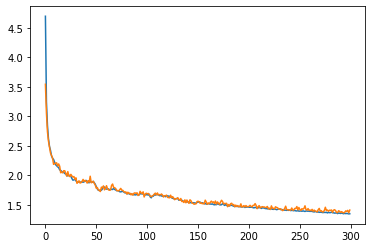

In [0]:
plt.plot(G_losses_train)
plt.plot(G_losses_test)

In [0]:
def save_result():
  for i, real_im in enumerate(validate_set):
      Generator.eval()
      r = real_im
      real_im = (0.2989*real_im[0,:,:] + 0.5870*real_im[1,:,:] + 0.1140*real_im[2,:,:])
      real_im = real_im.unsqueeze(0).unsqueeze(0).cuda()

      output = Generator(real_im)
      output = output[0].detach().cpu().clamp(0.0, 1.0)

      r = transforms.ToPILImage()(real_im)
      r = r.save("REAL"+str(i)+".jpg")

      PIL_img = transforms.ToPILImage()(output)
      PIL_img = PIL_img.save("RES"+str(i)+".jpg")
      Generator.train()

In [0]:
save_result()

ValueError: ignored

In [0]:
def d_save_pic(i):
  Generator.eval()
  im = real = validate_set[i]
  gray_scale = im = (0.2989*im[0,:,:] + 0.5870*im[1,:,:] + 0.1140*im[2,:,:])
  #im = (im[0,:,:] + im[1,:,:] + im[2,:,:])/3
  im = im.unsqueeze(0).unsqueeze(0).cuda()
  
  output = Generator(im)
  #output = torch.cat([output, im], dim=1)
  p = output[0].detach().cpu()
  p = p.clamp(0.0, 1.0)
  
  real_img = transforms.ToPILImage()(real)
  real_img = real_img.save("real"+str(i)+".jpg")

  PIL_img = transforms.ToPILImage()(p)
  PIL_img = PIL_img.save("res" + str(i) + ".jpg")

  bw_img = transforms.ToPILImage()(gray_scale)
  bw_img = bw_img.save("bw" + str(i) + ".jpg")

  Generator.train()

In [0]:
for i in range(12):
    d_save_pic(i)

In [0]:
D = "content"


In [0]:
torch.save(Generator.state_dict(), G)

In [0]:
torch.save(Discriminator.state_dict(), D)

#TO-DO:


1.   Implement adaptive learning rate.
2.   Make the model work with LAB images.
3.   See if you overfit, and if you do try data augmentation.
4.   Remove all inplace operations.
